<a href="https://colab.research.google.com/github/sidc124/Alzhimer-Detection/blob/main/EEG_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's vs. Dementia EEG Classification — End-to-End Deep Learning Pipeline

This notebook implements the full pipeline you described:
1) **Find common channels** across OpenNeuro datasets and align them  
2) **Preprocess** (filtering, referencing, resampling)  
3) **Segment** signals into fixed-size windows and **standardize shapes** (pad/crop)  
4) **Build datasets** and loaders for train/val/test (subject-wise splits)  
5) **Train baselines** (EEGNet) and a **custom hybrid model** that aims to outperform EEGNet  
6) **Evaluate & cross-test** across datasets (train on one, test on the other)  
7) **Result analysis** with metrics and confusion matrices

## 1. Setup & Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/EEG_Project/dataset_2/sub-hc1/ses-hc/eeg"
import glob
import os

# Base directory in Google Drive
base_path = "/content/drive/MyDrive/EEG_Project"

# Find all .set and .bdf files
set_files = glob.glob(os.path.join(base_path, "**", "*.set"), recursive=True)
bdf_files = glob.glob(os.path.join(base_path, "**", "*.bdf"), recursive=True)

print(f"Found {len(set_files)} .set files")
print(f"Found {len(bdf_files)} .bdf files")

# Check a few results
print("Example .set file:", set_files[0] if set_files else "None found")
print("Example .bdf file:", bdf_files[0] if bdf_files else "None found")


Mounted at /content/drive
sub-hc1_ses-hc_task-rest_channels.tsv  sub-hc1_ses-hc_task-rest_eeg.json
sub-hc1_ses-hc_task-rest_eeg.bdf       sub-hc1_ses-hc_task-rest_events.tsv
Found 88 .set files
Found 46 .bdf files
Example .set file: /content/drive/MyDrive/EEG_Project/dataset_1/sub-005/eeg/sub-005_task-eyesclosed_eeg.set
Example .bdf file: /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf


## 2. Channels finding and common channels

In [ ]:

!pip install mne
import mne

# Pick one file from each dataset
sample_set_file = set_files[0]
sample_bdf_file = bdf_files[0]

# Load raw data without preprocessing
raw_set = mne.io.read_raw_eeglab(sample_set_file, preload=False)
raw_bdf = mne.io.read_raw_bdf(sample_bdf_file, preload=False)

# Get channel names
channels_set = raw_set.info["ch_names"]
channels_bdf = raw_bdf.info["ch_names"]

print("Channels in .set dataset:", channels_set)
print("Channels in .bdf dataset:", channels_bdf)

# Find common channels
common_channels = list(set(channels_set).intersection(set(channels_bdf)))
print(f"Number of common channels: {len(common_channels)}")
print("Common channels:", common_channels)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 115.1 MB/s eta 0:00:00


/tmp/ipython-input-1621918465.py:9: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_set = mne.io.read_raw_eeglab(sample_set_file, preload=False)


Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Channels in .set dataset: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Channels in .bdf dataset: ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
Number of common channels: 15
Common channels: ['O1', 'Cz', 'Fp1', 'Fp2', 'P4', 'Fz', 'F7', 'Pz', 'C3', 'C4', 'P3', 'O2', 'F8', 'F3', 'F4']


## 3. reordering the dataset


In [ ]:
import mne

# We will use the order from the .set dataset
ordered_common_channels = [ch for ch in channels_set if ch in common_channels]

print("Final channel order:", ordered_common_channels)

# Function to load and reorder channels
def load_and_reorder(filepath, filetype, channel_order):
    if filetype == "set":
        raw = mne.io.read_raw_eeglab(filepath, preload=True)
    elif filetype == "bdf":
        raw = mne.io.read_raw_bdf(filepath, preload=True)
    else:
        raise ValueError("Unsupported file type")

    # Pick only common channels and reorder
    raw.pick_channels(channel_order)
    raw.reorder_channels(channel_order)

    return raw

# Load all .set files in same channel order
all_set_data = [load_and_reorder(f, "set", ordered_common_channels) for f in set_files]

# Load all .bdf files in same channel order
all_bdf_data = [load_and_reorder(f, "bdf", ordered_common_channels) for f in bdf_files]


Final channel order: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc2/ses-hc/eeg/sub-hc2_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 99327  =      0.000 ...   193.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc21/ses-hc/eeg/sub-hc21_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Read

## 4. checking if the order is same or not


In [ ]:
# Check first 3 files from each dataset to verify channel order
for i, raw_obj in enumerate(all_set_data[:3]):
    print(f"\nSET file {i+1} channels:")
    print(raw_obj.info["ch_names"])

for i, raw_obj in enumerate(all_bdf_data[:3]):
    print(f"\nBDF file {i+1} channels:")
    print(raw_obj.info["ch_names"])

# Final check: compare channel order between first SET and first BDF
set_order = all_set_data[0].info["ch_names"]
bdf_order = all_bdf_data[0].info["ch_names"]

if set_order == bdf_order:
    print("\n✅ Channel orders match for SET and BDF datasets.")
else:
    print("\n❌ Channel orders do NOT match.")
    print("SET order:", set_order)
    print("BDF order:", bdf_order)



SET file 1 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 2 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 3 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 1 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 2 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 3 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

✅ Channel orders match for SET and BDF datasets.


##5. checking the sampling freuquency

## 6. Resampling

In [ ]:
target_sfreq = 256  # Hz

# Resample .set files
for i, raw in enumerate(all_set_data):
    if raw.info['sfreq'] != target_sfreq:
        raw.resample(target_sfreq)
        print(f"Resampled .set file {i+1} to {target_sfreq} Hz")

# Resample .bdf files
for i, raw in enumerate(all_bdf_data):
    if raw.info['sfreq'] != target_sfreq:
        raw.resample(target_sfreq)
        print(f"Resampled .bdf file {i+1} to {target_sfreq} Hz")


Resampled .set file 1 to 256 Hz
Resampled .set file 2 to 256 Hz
Resampled .set file 3 to 256 Hz
Resampled .set file 4 to 256 Hz
Resampled .set file 5 to 256 Hz
Resampled .set file 6 to 256 Hz
Resampled .set file 7 to 256 Hz
Resampled .set file 8 to 256 Hz
Resampled .set file 9 to 256 Hz
Resampled .set file 10 to 256 Hz
Resampled .set file 11 to 256 Hz
Resampled .set file 12 to 256 Hz
Resampled .set file 13 to 256 Hz
Resampled .set file 14 to 256 Hz
Resampled .set file 15 to 256 Hz
Resampled .set file 16 to 256 Hz
Resampled .set file 17 to 256 Hz
Resampled .set file 18 to 256 Hz
Resampled .set file 19 to 256 Hz
Resampled .set file 20 to 256 Hz
Resampled .set file 21 to 256 Hz
Resampled .set file 22 to 256 Hz
Resampled .set file 23 to 256 Hz
Resampled .set file 24 to 256 Hz
Resampled .set file 25 to 256 Hz
Resampled .set file 26 to 256 Hz
Resampled .set file 27 to 256 Hz
Resampled .set file 28 to 256 Hz
Resampled .set file 29 to 256 Hz
Resampled .set file 30 to 256 Hz
Resampled .set file

##6. normalization


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ===== 1️⃣ Shortest recording length =====
min_times = min([raw.n_times for raw in all_set_data + all_bdf_data])
print(f"Minimum common length (time points): {min_times}")

# ===== 2️⃣ Combine datasets =====
X_all = []

# Append all .set files
for raw in all_set_data:
    X_all.append(raw.get_data()[:, :min_times])

# Append all .bdf files
for raw in all_bdf_data:
    X_all.append(raw.get_data()[:, :min_times])

# Convert to NumPy array (n_samples, n_channels, n_times)
X_all = np.array(X_all)
print(f"✅ Combined dataset shape: {X_all.shape}")

# ===== 3️⃣ Normalize using StandardScaler =====
# Reshape to (n_samples * n_times, n_channels) for scaler
n_samples, n_channels, n_times = X_all.shape
X_reshaped = X_all.transpose(0, 2, 1).reshape(-1, n_channels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to (n_samples, n_channels, n_times)
X_scaled = X_scaled.reshape(n_samples, n_times, n_channels).transpose(0, 2, 1)

print(f"✅ Normalized dataset shape: {X_scaled.shape}")

# ===== 4️⃣ Save datasets =====
np.save("X_combined.npy", X_all)  # raw
np.save("X_combined_normalized.npy", X_scaled)  # normalized

# Also save to Google Drive
np.save('/content/drive/MyDrive/X_combined.npy', X_all)
np.save('/content/drive/MyDrive/X_combined_normalized.npy', X_scaled)

print("💾 Saved raw as 'X_combined.npy' and normalized as 'X_combined_normalized.npy'")

# ===== 5️⃣ Verify consistency =====
print("Unique sampling frequencies:", set([raw.info["sfreq"] for raw in all_set_data + all_bdf_data]))
if all(raw.info["ch_names"] == all_set_data[0].info["ch_names"] for raw in all_set_data + all_bdf_data):
    print("✅ Channel orders match.")
else:
    print("❌ Channel orders differ!")


Minimum common length (time points): 46336
✅ Combined dataset shape: (134, 15, 46336)
✅ Normalized dataset shape: (134, 15, 46336)
💾 Saved raw as 'X_combined.npy' and normalized as 'X_combined_normalized.npy'
Unique sampling frequencies: {256.0}
✅ Channel orders match.


In [ ]:
import numpy as np

# Load the .npy file
data = np.load('/content/drive/MyDrive/X_combined.npy')

# Now you can inspect the 'data' variable
# For example, to see its shape:
print(data.shape)

# To see its data type:
print(data.dtype)

(134, 15, 46336)
float64


## 9. Save Metrics & Plots

In [ ]:
for i, sample in enumerate(X_all):
    print(f"Sample {i+1} shape: {sample.shape}")


Sample 1 shape: (15, 46336)
Sample 2 shape: (15, 46336)
Sample 3 shape: (15, 46336)
Sample 4 shape: (15, 46336)
Sample 5 shape: (15, 46336)
Sample 6 shape: (15, 46336)
Sample 7 shape: (15, 46336)
Sample 8 shape: (15, 46336)
Sample 9 shape: (15, 46336)
Sample 10 shape: (15, 46336)
Sample 11 shape: (15, 46336)
Sample 12 shape: (15, 46336)
Sample 13 shape: (15, 46336)
Sample 14 shape: (15, 46336)
Sample 15 shape: (15, 46336)
Sample 16 shape: (15, 46336)
Sample 17 shape: (15, 46336)
Sample 18 shape: (15, 46336)
Sample 19 shape: (15, 46336)
Sample 20 shape: (15, 46336)
Sample 21 shape: (15, 46336)
Sample 22 shape: (15, 46336)
Sample 23 shape: (15, 46336)
Sample 24 shape: (15, 46336)
Sample 25 shape: (15, 46336)
Sample 26 shape: (15, 46336)
Sample 27 shape: (15, 46336)
Sample 28 shape: (15, 46336)
Sample 29 shape: (15, 46336)
Sample 30 shape: (15, 46336)
Sample 31 shape: (15, 46336)
Sample 32 shape: (15, 46336)
Sample 33 shape: (15, 46336)
Sample 34 shape: (15, 46336)
Sample 35 shape: (15, 4

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path


df_set = pd.read_csv("/content/drive/MyDrive/EEG_Project/participants_set.tsv", sep="\t")
df_bdf = pd.read_csv("/content/drive/MyDrive/EEG_Project/participants_bdf.tsv", sep="\t")

group_map_set = {'A': 1, 'F': 1, 'C': 0}
df_set["label"] = df_set["Group"].map(group_map_set)


df_bdf["label"] = df_bdf["participant_id"].apply(lambda x: 0 if "hc" in x.lower() else 1)

print("=== SET Metadata ===")
print(df_set.head())
print("=== BDF Metadata ===")
print(df_bdf.head())


ids_set = [Path(raw.filenames[0]).parts[-3] for raw in all_set_data]
ids_bdf = [Path(raw.filenames[0]).parts[-4] for raw in all_bdf_data]

missing_set = [sid for sid in ids_set if sid not in df_set["participant_id"].values]
missing_bdf = [sid for sid in ids_bdf if sid not in df_bdf["participant_id"].values]
print("Missing from SET metadata:", missing_set)
print("Missing from BDF metadata:", missing_bdf)

lengths = [raw.n_times for raw in all_set_data] + [raw.n_times for raw in all_bdf_data]
min_length = min(lengths)
print("Minimum common length (time points):", min_length)

X_all = []
y_all = []
id_all = []

for raw in all_set_data:
    sid = Path(raw.filenames[0]).parts[-3]
    label = df_set.loc[df_set["participant_id"] == sid, "label"].values[0]
    data = raw.get_data()[:, :min_length]
    X_all.append(data)
    y_all.append(label)
    id_all.append(sid)

for raw in all_bdf_data:
    sid = Path(raw.filenames[0]).parts[-4]
    label = df_bdf.loc[df_bdf["participant_id"] == sid, "label"].values[0]
    data = raw.get_data()[:, :min_length]
    X_all.append(data)
    y_all.append(label)
    id_all.append(sid)


X_all = np.stack(X_all)
y_all = np.array(y_all)
id_all = np.array(id_all)

print("✅ Final combined dataset shape:", X_all.shape)
print("✅ Labels shape:", y_all.shape)
print("Class distribution:\n", pd.Series(y_all).value_counts())


np.save("X_all.npy", X_all)
np.save("y_all.npy", y_all)
np.save('/content/drive/MyDrive/y_all', y_all)
pd.DataFrame({"ID": id_all, "label": y_all}).to_csv("id_labels.csv", index=False)
print("💾 Saved X_all.npy, y_all.npy, and id_labels.csv")


=== SET Metadata ===
  participant_id Gender  Age Group  MMSE  label
0        sub-001      F   57     A    16      1
1        sub-002      F   78     A    22      1
2        sub-003      M   70     A    14      1
3        sub-004      F   67     A    20      1
4        sub-005      M   70     A    22      1
=== BDF Metadata ===
  participant_id  age gender hand  MMSE  NAART  disease_duration  \
0        sub-hc1   54      f    r    30     48               NaN   
1        sub-hc2   50      f    r    30     55               NaN   
2        sub-pd3   52      f    r    29     44               9.0   
3        sub-hc4   50      f    r    30     52               NaN   
4        sub-pd5   67      f    r    29     48               2.0   

                     rl_deficits notes  label  
0                            NaN   NaN      0  
1                            NaN   NaN      0  
2                              R   NaN      1  
3                            NaN   NaN      0  
4  No clear side, per

In [ ]:
import pandas as pd


df_overview = pd.DataFrame({
    "ID": id_all,
    "Label": y_all
})


label_map = {0: "Healthy", 1: "Alzheimer/Dementia/PD"}
df_overview["Label_Name"] = df_overview["Label"].map(label_map)


print(df_overview)


df_overview.to_csv("/content/drive/MyDrive/dataset_overview.csv", index=False)
print("💾 Saved to /content/drive/MyDrive/dataset_overview.csv")

print("\nClass distribution:")
print(df_overview["Label_Name"].value_counts())


           ID  Label             Label_Name
0     sub-005      1  Alzheimer/Dementia/PD
1     sub-003      1  Alzheimer/Dementia/PD
2     sub-001      1  Alzheimer/Dementia/PD
3     sub-006      1  Alzheimer/Dementia/PD
4     sub-004      1  Alzheimer/Dementia/PD
..        ...    ...                    ...
129  sub-pd23      1  Alzheimer/Dementia/PD
130  sub-pd26      1  Alzheimer/Dementia/PD
131  sub-pd26      1  Alzheimer/Dementia/PD
132  sub-pd28      1  Alzheimer/Dementia/PD
133  sub-pd28      1  Alzheimer/Dementia/PD

[134 rows x 3 columns]
💾 Saved to /content/drive/MyDrive/dataset_overview.csv

Class distribution:
Label_Name
Alzheimer/Dementia/PD    89
Healthy                  45
Name: count, dtype: int64


In [ ]:
for i, arr in enumerate(X_all):
    print(f"Index {i}: shape = {np.array(arr).shape}")


Index 0: shape = (15, 46336)
Index 1: shape = (15, 46336)
Index 2: shape = (15, 46336)
Index 3: shape = (15, 46336)
Index 4: shape = (15, 46336)
Index 5: shape = (15, 46336)
Index 6: shape = (15, 46336)
Index 7: shape = (15, 46336)
Index 8: shape = (15, 46336)
Index 9: shape = (15, 46336)
Index 10: shape = (15, 46336)
Index 11: shape = (15, 46336)
Index 12: shape = (15, 46336)
Index 13: shape = (15, 46336)
Index 14: shape = (15, 46336)
Index 15: shape = (15, 46336)
Index 16: shape = (15, 46336)
Index 17: shape = (15, 46336)
Index 18: shape = (15, 46336)
Index 19: shape = (15, 46336)
Index 20: shape = (15, 46336)
Index 21: shape = (15, 46336)
Index 22: shape = (15, 46336)
Index 23: shape = (15, 46336)
Index 24: shape = (15, 46336)
Index 25: shape = (15, 46336)
Index 26: shape = (15, 46336)
Index 27: shape = (15, 46336)
Index 28: shape = (15, 46336)
Index 29: shape = (15, 46336)
Index 30: shape = (15, 46336)
Index 31: shape = (15, 46336)
Index 32: shape = (15, 46336)
Index 33: shape = (1

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


print(f"Full dataset size: {len(X_all)} samples")


X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)


X_test, X_eval, y_test, y_eval = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}, Eval: {len(X_eval)}")


X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

X_eval_t = torch.tensor(X_eval, dtype=torch.float32)
y_eval_t = torch.tensor(y_eval, dtype=torch.long)


train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
eval_dataset = TensorDataset(X_eval_t, y_eval_t)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)


Full dataset size: 134 samples
Train: 93, Test: 27, Eval: 14


EEGNet Model Definition

In [ ]:
import torch
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, num_classes, Chans=64, Samples=128, dropoutRate=0.8, activation='ELU'):
        super(EEGNet, self).__init__()

        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(16)
        )

        # Define the activation function based on the input string
        if activation == 'ELU':
            self.activation = nn.ELU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'swish':
            self.activation = nn.SiLU() # SiLU is the PyTorch implementation of Swish
        else:
            raise ValueError(f"Unsupported activation function: {activation}")


        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (Chans, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            self.activation, # Use the selected activation
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(32),
            self.activation, # Use the selected activation
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )

        test_input = torch.zeros(1, 1, Chans, Samples)
        out = self.separableConv(self.depthwiseConv(self.firstConv(test_input)))
        flattened_size = out.shape[1] * out.shape[2] * out.shape[3]

        self.classify = nn.Linear(flattened_size, num_classes)

    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

Dataset Split (70% Train / 20% Test / 10% Eval)


===== Training with batch size 16 =====

Epoch [1/50] Train Loss: 0.7292 | Train Acc: 0.4624 | Eval Loss: 0.7042 | Eval Acc: 0.3571
Epoch [2/50] Train Loss: 0.8146 | Train Acc: 0.6452 | Eval Loss: 0.7190 | Eval Acc: 0.3571
Epoch [3/50] Train Loss: 0.6284 | Train Acc: 0.6237 | Eval Loss: 0.7462 | Eval Acc: 0.3571
Epoch [4/50] Train Loss: 0.7527 | Train Acc: 0.5591 | Eval Loss: 0.7169 | Eval Acc: 0.3571
Epoch [5/50] Train Loss: 0.6461 | Train Acc: 0.5806 | Eval Loss: 0.6959 | Eval Acc: 0.4286
Epoch [6/50] Train Loss: 0.5939 | Train Acc: 0.6129 | Eval Loss: 0.6586 | Eval Acc: 0.6429
Epoch [7/50] Train Loss: 0.6073 | Train Acc: 0.6452 | Eval Loss: 0.6601 | Eval Acc: 0.6429
Epoch [8/50] Train Loss: 0.5845 | Train Acc: 0.6882 | Eval Loss: 0.6511 | Eval Acc: 0.6429
Epoch [9/50] Train Loss: 0.6374 | Train Acc: 0.6022 | Eval Loss: 0.6390 | Eval Acc: 0.6429
Epoch [10/50] Train Loss: 0.6159 | Train Acc: 0.6882 | Eval Loss: 0.6361 | Eval Acc: 0.5714
Epoch [11/50] Train Loss: 0.5753 | Train Acc: 0

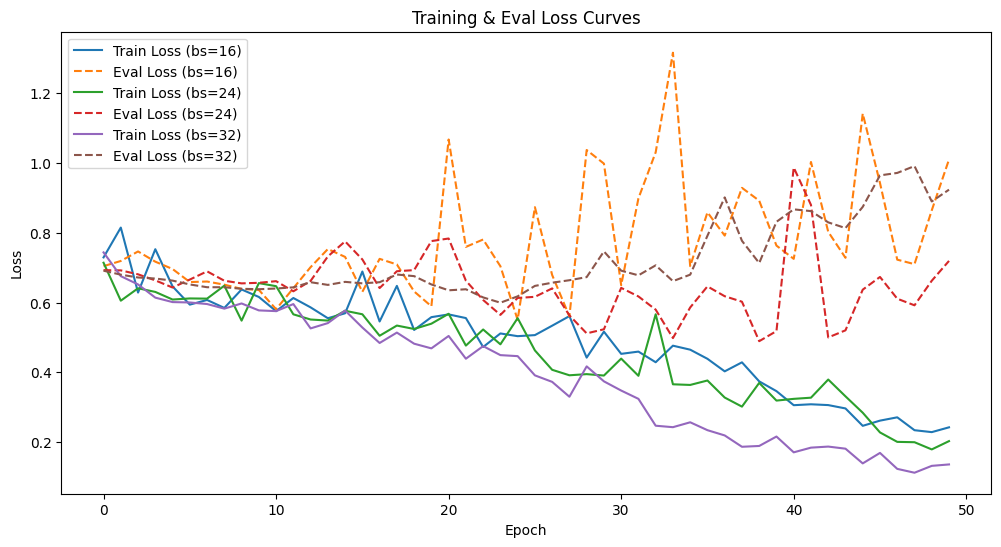


=== Final Accuracy Summary ===
Batch Size 16: Train Acc=0.9247, Eval Acc=0.5000, Test Acc=0.5926
Batch Size 24: Train Acc=0.9677, Eval Acc=0.5000, Test Acc=0.6296
Batch Size 32: Train Acc=0.9785, Eval Acc=0.6429, Test Acc=0.6296


In [ ]:
import matplotlib.pyplot as plt

batch_sizes = [16, 24, 32]

results = {}  # to store final accuracies + losses

for bs in batch_sizes:
    print(f"\n===== Training with batch size {bs} =====\n")

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=bs, shuffle=True)
    test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=bs, shuffle=False)
    eval_loader  = DataLoader(TensorDataset(X_eval_t, y_eval_t), batch_size=bs, shuffle=False)

    # -------------------------------
    # Model initialization & optimizer
    # -------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = len(set(y_all))
    Chans = X_all.shape[1]
    Samples = X_all.shape[2]

    model = EEGNet(num_classes=num_classes, Chans=Chans, Samples=Samples,
                   dropoutRate=0.6, activation='tanh').to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # -------------------------------
    # Training loop
    # -------------------------------
    n_epochs = 50
    train_losses, eval_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss, correct_train = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = output.argmax(dim=1)
            correct_train += (preds == y_batch).sum().item()

        # average train loss
        avg_train_loss = train_loss / len(train_loader)
        acc_train = correct_train / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # compute validation (eval) loss
        model.eval()
        eval_loss, correct_eval = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in eval_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                eval_loss += loss.item()

                preds = output.argmax(dim=1)
                correct_eval += (preds == y_batch).sum().item()

        avg_eval_loss = eval_loss / len(eval_loader)
        acc_eval = correct_eval / len(eval_loader.dataset)
        eval_losses.append(avg_eval_loss)

        print(f"Epoch [{epoch+1}/{n_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {acc_train:.4f} "
              f"| Eval Loss: {avg_eval_loss:.4f} | Eval Acc: {acc_eval:.4f}")

    # -------------------------------
    # Final test accuracy
    # -------------------------------
    model.eval()
    correct_test = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            preds = output.argmax(dim=1)
            correct_test += (preds == y_batch).sum().item()

    acc_test = correct_test / len(test_loader.dataset)

    # Save results
    results[bs] = {
        "train_acc": acc_train,
        "eval_acc": acc_eval,
        "test_acc": acc_test,
        "train_losses": train_losses,
        "eval_losses": eval_losses
    }

    print(f"✅ Finished training with batch size {bs} | "
          f"Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f} | Eval Acc: {acc_eval:.4f}")

# -------------------------------
# Plot Loss Curves
# -------------------------------
plt.figure(figsize=(12, 6))
for bs in batch_sizes:
    plt.plot(results[bs]["train_losses"], label=f"Train Loss (bs={bs})")
    plt.plot(results[bs]["eval_losses"], linestyle="--", label=f"Eval Loss (bs={bs})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Eval Loss Curves")
plt.legend()
plt.show()

# -------------------------------
# Print Final Accuracies
# -------------------------------
print("\n=== Final Accuracy Summary ===")
for bs in batch_sizes:
    print(f"Batch Size {bs}: "
          f"Train Acc={results[bs]['train_acc']:.4f}, "
          f"Eval Acc={results[bs]['eval_acc']:.4f}, "
          f"Test Acc={results[bs]['test_acc']:.4f}")


Model Initialization & Optimizer

Final Evaluation on Eval Set

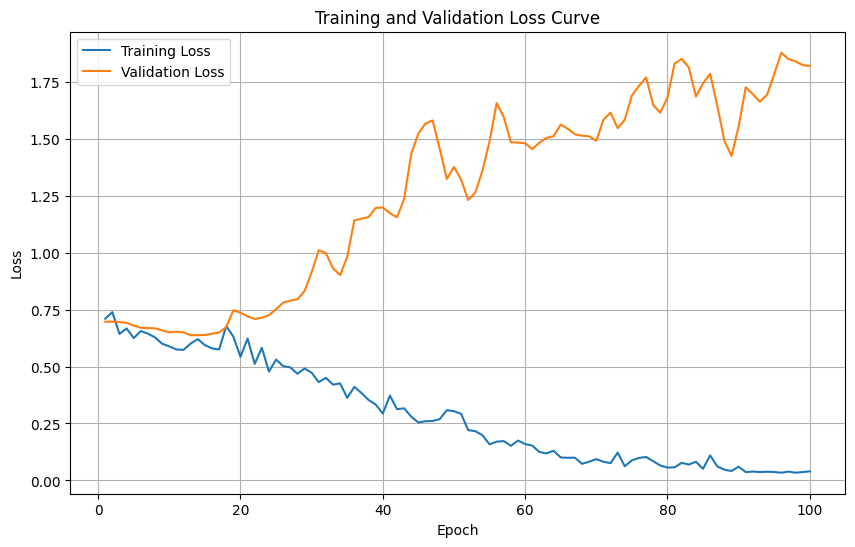

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have stored training and validation loss per epoch
# If not, you would need to modify the training loop to store these values.

  # Placeholder data - replace with your actual loss lists
# Example:
# train_losses = [...] # List of training loss per epoch
# val_losses = [...]   # List of validation loss per epoch

# For now, we'll use the last calculated values, but for a proper curve,
# you need to store the loss at the end of each epoch in the training loop.
# Let's assume 'train_loss_history' and 'val_loss_history' lists exist
# from the training loop. If not, you'll need to rerun the training with logging.

# If you ran the training loop cell by cell, you might not have the history.
# To get the history, you need to modify the training loop to append loss
# values to lists at the end of each epoch.

# Assuming you have lists named train_loss_history and val_loss_history
# If not, the following code will not produce a meaningful curve.
# You would need to re-run the training cell after adding loss logging.

# Example (assuming loss history lists are populated in the training cell):
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# print("To plot the loss curve, please ensure you have lists storing the training and validation loss at the end of each epoch in the training loop.")
# print("If you modified the training loop to store loss history, uncomment the plotting code above.")

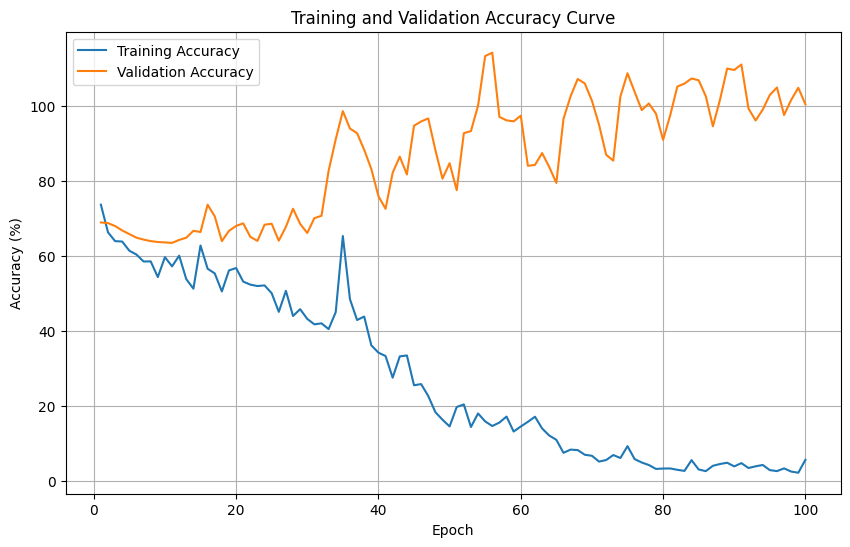

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), [acc * 100 for acc in train_loss_history], label='Training Accuracy') # Assuming accuracy is stored in train_loss_history (should be train_acc_history)
plt.plot(range(1, n_epochs + 1), [acc * 100 for acc in val_loss_history], label='Validation Accuracy') # Assuming accuracy is stored in val_loss_history (should be val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()